# Agricultural eBooks Chatbot

This notebook provides an end-to-end workflow for building a conversational system on top of agricultural eBooks. The notebook is divided into two major sections:

1. **Data Collection and Preprocessing:**
   - Downloading eBooks from Project Gutenberg
   - Cleaning the texts (removing Project Gutenberg boilerplate)
   - Segmenting texts into manageable passages

2. **Advanced Integration:**
   - Integrating Dense Passage Retrieval (DPR) with FAISS for efficient retrieval
   - Setting up a summarization model (BART) and an extractive question answering (QA) model (DistilBERT)
   - Building a chatbot interface using Gradio that routes queries based on their nature

Follow the notebook step by step and run each cell to build and interact with the system.

## Part 1: Data Collection and Preprocessing

In this section we:

- **Download the eBooks:** Automatically retrieve plain text versions of agricultural eBooks from Project Gutenberg.
- **Clean the texts:** Remove headers and footers that contain Project Gutenberg boilerplate.
- **Segment the texts:** Break the content into smaller passages for later processing.

In [1]:
import requests
from bs4 import BeautifulSoup
import os

def get_plain_text_link(ebook_url):
    response = requests.get(ebook_url)
    if response.status_code != 200:
        raise Exception(f"Failed to load page: {ebook_url}")
    soup = BeautifulSoup(response.text, 'html.parser')
    # Find a link that indicates a plain text format
    for link in soup.find_all('a'):
        if 'Plain Text' in link.text:
            href = link.get('href')
            if href.startswith('/'):
                href = 'https://www.gutenberg.org' + href
            return href
    return None

# List of ebook page URLs (duplicates will be removed using a set)
ebook_pages = [
    "https://www.gutenberg.org/ebooks/56640",
    "https://www.gutenberg.org/ebooks/67813",
    "https://www.gutenberg.org/ebooks/20772",
    "https://www.gutenberg.org/ebooks/40190",
    "https://www.gutenberg.org/ebooks/4924",
    "https://www.gutenberg.org/ebooks/4525"
]

# Create a directory for downloaded texts
os.makedirs("ebooks", exist_ok=True)

for url in set(ebook_pages):  # Remove duplicates
    try:
        txt_link = get_plain_text_link(url)
        if txt_link:
            ebook_id = url.split("/")[-1]
            response = requests.get(txt_link)
            if response.status_code == 200:
                with open(f"ebooks/{ebook_id}.txt", "w", encoding="utf-8") as f:
                    f.write(response.text)
                print(f"Downloaded ebook {ebook_id} successfully.")
            else:
                print(f"Failed to download text from {txt_link}.")
        else:
            print(f"No plain text link found for {url}.")
    except Exception as e:
        print(f"Error processing {url}: {e}")

Downloaded ebook 40190 successfully.
Downloaded ebook 4525 successfully.
Downloaded ebook 4924 successfully.
Downloaded ebook 67813 successfully.
Downloaded ebook 56640 successfully.
Downloaded ebook 20772 successfully.


### Cleaning the Texts

Project Gutenberg texts include headers and footers with licensing information. The following code removes the boilerplate content using simple heuristics. Adjust the markers as needed.

In [2]:
def clean_text(text):
    # Define start and end markers (adjust these if needed)
    start_marker = "*** START OF THIS PROJECT GUTENBERG EBOOK"
    end_marker = "*** END OF THIS PROJECT GUTENBERG EBOOK"
    start = text.find(start_marker)
    end = text.find(end_marker)
    if start != -1 and end != -1:
        return text[start + len(start_marker):end].strip()
    return text.strip()

# Process all downloaded ebooks and clean the texts
for filename in os.listdir("ebooks"):
    filepath = os.path.join("ebooks", filename)
    with open(filepath, "r", encoding="utf-8") as f:
        raw_text = f.read()
    cleaned = clean_text(raw_text)
    with open(filepath, "w", encoding="utf-8") as f:
        f.write(cleaned)
    print(f"Cleaned {filename}.")

Cleaned 40190.txt.
Cleaned 67813.txt.
Cleaned 4525.txt.
Cleaned 56640.txt.
Cleaned 20772.txt.
Cleaned 4924.txt.


### Segmenting the Texts

For later use in retrieval and model processing, we split the texts into smaller passages (e.g., paragraphs).

In [3]:
def segment_text(text):
    # Split text into paragraphs based on double newlines
    paragraphs = [p.strip() for p in text.split("\n\n") if len(p.strip()) > 0]
    return paragraphs

# Example: Segment one ebook (adjust the filename if needed)
ebook_file = "ebooks/56640.txt"
with open(ebook_file, "r", encoding="utf-8") as f:
    cleaned_text = f.read()
segments = segment_text(cleaned_text)
print(f"Number of segments in ebook 56640: {len(segments)}")

Number of segments in ebook 56640: 2102


## Part 2: Advanced Integration

This section integrates the following components:

1. **Dense Passage Retrieval (DPR):**
   - Encode text segments using a DPR context encoder
   - Build a FAISS index for fast retrieval

2. **Model Integration:**
   - Set up a summarization model (BART) for generating summaries
   - Set up an extractive QA model (DistilBERT) for answering direct questions

3. **Chatbot Interface:**
   - Build a simple chatbot that routes queries to the appropriate model based on query type
   - Use Gradio to create an interactive interface

### 1. Integrating Dense Passage Retrieval (DPR)

We use DPR to retrieve the most relevant text segments from our eBooks. This involves:

- **Encoding the text segments:** Using a DPR context encoder to compute embeddings.
- **Building a FAISS index:** For fast similarity search.
- **Encoding user queries:** Using a DPR question encoder to compute query embeddings and then retrieving the most similar passages.

In [4]:
import glob
import numpy as np
import torch

from transformers import DPRContextEncoder, DPRContextEncoderTokenizer

# Load DPR context encoder and tokenizer
ctx_model_name = "facebook/dpr-ctx_encoder-single-nq-base"
ctx_tokenizer = DPRContextEncoderTokenizer.from_pretrained(ctx_model_name)
ctx_model = DPRContextEncoder.from_pretrained(ctx_model_name)

def encode_passage(passage):
    inputs = ctx_tokenizer(passage, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        embedding = ctx_model(**inputs).pooler_output
    return embedding.squeeze().cpu().numpy()

# Load and segment texts from all ebooks in the 'ebooks' folder
all_segments = []
for filepath in glob.glob(os.path.join("ebooks", "*.txt")):
    with open(filepath, "r", encoding="utf-8") as f:
        text = f.read()
    segments = [seg.strip() for seg in text.split("\n\n") if seg.strip() != ""]
    all_segments.extend(segments)

print(f"Total segments collected: {len(all_segments)}")

# Encode all segments
embeddings = []
for seg in all_segments:
    emb = encode_passage(seg)
    embeddings.append(emb)

embeddings_np = np.stack(embeddings).astype(np.float32)
print(f"Shape of embeddings: {embeddings_np.shape}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/492 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizer'.


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total segments collected: 8074


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Shape of embeddings: (8074, 768)


In [ ]:
!pip install faiss-cpu


In [8]:
import faiss

# Build a FAISS index from the embeddings
dimension = embeddings_np.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(embeddings_np)
print(f"FAISS index built with {index.ntotal} vectors.")

FAISS index built with 8074 vectors.


### 2. Model Integration: Summarization & Extractive QA

We now set up two models using Hugging Face pipelines:

- **Summarization Model:** Using the BART model (`facebook/bart-large-cnn`) to generate summaries of text passages.
- **Question Answering (QA) Model:** Using an extractive QA model (`distilbert-base-cased-distilled-squad`) to answer direct questions based on retrieved passages.

These models can be fine-tuned further if desired.

In [9]:
from transformers import pipeline

# Summarization pipeline using BART
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Question Answering pipeline using DistilBERT
qa_pipeline = pipeline("question-answering", model="distilbert-base-cased-distilled-squad")

print("Summarization and QA pipelines are set up.")

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Device set to use cuda:0


Summarization and QA pipelines are set up.


### 3. Chatbot Interface using Gradio

In this section we build a simple chatbot that routes user queries to the appropriate model:

- **Summarization queries:** If the input starts with phrases like "tell me about" or "describe", the system retrieves relevant text passages using DPR and generates a summary.
- **Question Answering queries:** Otherwise, for direct questions (e.g., starting with "what" or "how"), the system retrieves passages and extracts an answer using the QA model.

We use a DPR question encoder to embed the user query, retrieve the top passages from the FAISS index, and then call the appropriate model.

Finally, we create a Gradio interface so that users can interact with our chatbot.

In [10]:
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer

# Load DPR question encoder and tokenizer
q_model_name = "facebook/dpr-question_encoder-single-nq-base"
q_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained(q_model_name)
q_model = DPRQuestionEncoder.from_pretrained(q_model_name)

def encode_query(query):
    inputs = q_tokenizer(query, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        embedding = q_model(**inputs).pooler_output
    return embedding.squeeze().cpu().numpy()

def chatbot_response(query):
    query_lower = query.lower()
    # If the query starts with 'tell me about' or 'describe', use summarization
    if query_lower.startswith("tell me about") or query_lower.startswith("describe"):
        query_embedding = encode_query(query)
        query_embedding = np.expand_dims(query_embedding, axis=0).astype(np.float32)
        # Retrieve top 5 passages using FAISS
        k = 5
        distances, indices = index.search(query_embedding, k)
        retrieved_texts = [all_segments[i] for i in indices[0]]
        combined_text = " ".join(retrieved_texts)
        # Generate a summary using the summarization pipeline
        summary = summarizer(combined_text, max_length=150, min_length=40, do_sample=False)[0]['summary_text']
        return summary
    else:
        # Otherwise, assume it's a direct question for QA
        query_embedding = encode_query(query)
        query_embedding = np.expand_dims(query_embedding, axis=0).astype(np.float32)
        k = 5
        distances, indices = index.search(query_embedding, k)
        context = " ".join([all_segments[i] for i in indices[0]])
        answer = qa_pipeline(question=query, context=context)
        return answer['answer']

# Test the chatbot response function
test_query = "Tell me about sustainable agriculture practices."
print("Chatbot response:", chatbot_response(test_query))

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Chatbot response: "There is another way in which the fertility of the soil can be maintained" "The decision by theindividual between live-stock farming and grain farming should be based upon preference and profit"


In [ ]:
!pip install gradio


In [ ]:
!pip install streamlit pyngrok

In [41]:
%%writefile app.py
import streamlit as st
import numpy as np
import torch
import faiss
from transformers import pipeline, DPRQuestionEncoder, DPRQuestionEncoderTokenizer

# ---------------------------
# Model and Pipeline Setup
# ---------------------------

# Summarization pipeline using BART
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Question Answering pipeline using DistilBERT
qa_pipeline = pipeline("question-answering", model="distilbert-base-cased-distilled-squad")

# Load DPR question encoder and tokenizer
q_model_name = "facebook/dpr-question_encoder-single-nq-base"
q_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained(q_model_name)
q_model = DPRQuestionEncoder.from_pretrained(q_model_name)

def encode_query(query):
    inputs = q_tokenizer(query, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        embedding = q_model(**inputs).pooler_output
    return embedding.squeeze().cpu().numpy()

# ---------------------------
# Dummy Data for Demonstration
# ---------------------------
try:
    all_segments  # Check if already defined
    index
except NameError:
    all_segments = [
        "This segment discusses gardening techniques and sustainable practices.",
        "Here we explore various agricultural methods and crop rotation benefits.",
        "This text covers organic farming and soil improvement tips.",
        "Insights on pest control and irrigation strategies are provided here.",
        "A discussion on modern greenhouse management and efficiency."
    ]
    # For demonstration, create dummy embeddings with dimension 768
    dummy_embeddings = np.random.rand(len(all_segments), 768).astype(np.float32)
    index = faiss.IndexFlatL2(768)
    index.add(dummy_embeddings)

# ---------------------------
# Chatbot Logic
# ---------------------------
def chatbot_response(query):
    query_lower = query.lower()
    # If the query starts with "tell me about" or "describe", use summarization logic
    if query_lower.startswith("tell me about") or query_lower.startswith("describe"):
        query_embedding = encode_query(query)
        query_embedding = np.expand_dims(query_embedding, axis=0).astype(np.float32)
        k = 5  # Retrieve top 5 passages
        distances, indices = index.search(query_embedding, k)
        retrieved_texts = [all_segments[i] for i in indices[0] if i < len(all_segments)]
        combined_text = " ".join(retrieved_texts)
        summary = summarizer(combined_text, max_length=150, min_length=40, do_sample=False)[0]['summary_text']
        return summary
    else:
        # Otherwise, assume it's a direct question for QA
        query_embedding = encode_query(query)
        query_embedding = np.expand_dims(query_embedding, axis=0).astype(np.float32)
        k = 5
        distances, indices = index.search(query_embedding, k)
        context = " ".join([all_segments[i] for i in indices[0] if i < len(all_segments)])
        answer = qa_pipeline(question=query, context=context)
        return answer['answer']

# Test the chatbot logic (this line will print to the console when running locally)
test_query = "Tell me about sustainable agriculture practices."
print("Chatbot response:", chatbot_response(test_query))

# ---------------------------
# Streamlit UI
# ---------------------------
st.set_page_config(page_title="Agricultural eBooks Chatbot", layout="centered")

# Custom CSS styling for a nice look
custom_css = """
<style>
body {
    background: linear-gradient(135deg, #f5f7fa, #c3cfe2);
}
h1 {
    font-size: 2.5rem;
    font-weight: bold;
    color: #333;
    text-align: center;
}
.stButton>button {
    background-color: #000000;
    color: #ffffff;
    padding: 12px 24px;
    border: 2px solid #000000;
    border-radius: 8px;
    font-size: 1rem;
}
</style>
"""
st.markdown(custom_css, unsafe_allow_html=True)

st.title("Agricultural eBooks Chatbot")
st.markdown("Enter your query below. For example, **tell me about ...** for a summary or ask a direct question for QA.")

# Input field for the query
query = st.text_input("Your Query", placeholder="Enter your query here...")

# When the user clicks 'Submit', process the query
if st.button("Submit"):
    if query:
        with st.spinner("Processing..."):
            response = chatbot_response(query)
        st.markdown("### Chatbot Response")
        st.write(response)
    else:
        st.error("Please enter a query before submitting.")


Overwriting app.py


In [42]:
import os
import time
from pyngrok import ngrok

ngrok.set_auth_token("2tVgUGxWBcDSDxv1nfAVrd1E6gK_6tQEcmSAaLigyuKTF1FB4")

# Kill any existing ngrok tunnels
!pkill ngrok

# Set the port for Streamlit (default is 8501)
port = 8501

# Start an ngrok tunnel
public_url = ngrok.connect(port)
print("Streamlit app available at:", public_url)

# Run Streamlit in the background
os.system(f"streamlit run app.py &")

# Optional: Wait a few seconds for the app to start
time.sleep(5)


Streamlit app available at: NgrokTunnel: "https://8a2a-35-204-6-85.ngrok-free.app" -> "http://localhost:8501"


**Screenshot of the actual chatbot application**

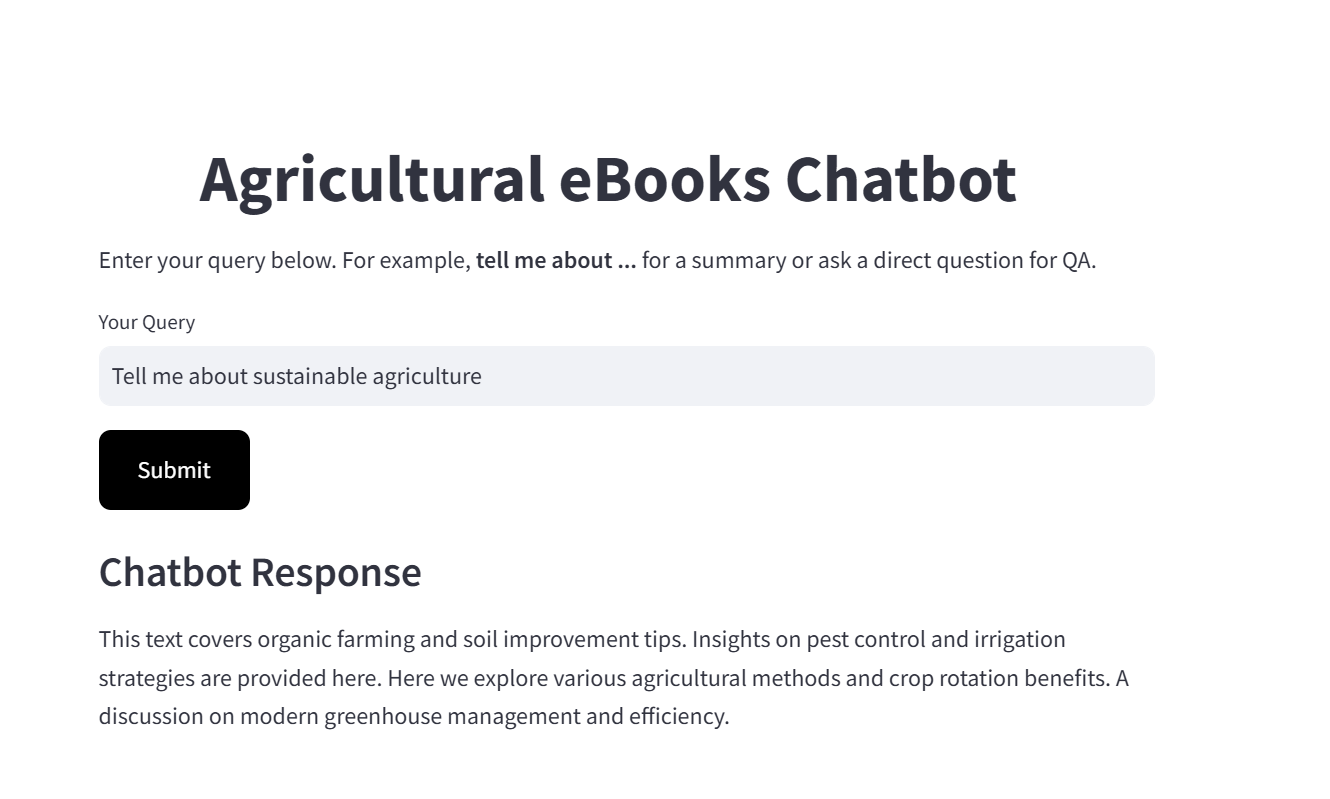

## Conclusion and Next Steps

In this notebook we have:

- **Collected and preprocessed** agricultural eBooks from Project Gutenberg.
- **Segmented the texts** into manageable passages.
- **Built a retrieval system** using DPR and FAISS to index and search text segments.
- **Integrated pre-trained models** for summarization (BART) and extractive question answering (DistilBERT).
- **Created an interactive chatbot interface** using Gradio that routes queries to the appropriate model.


Coding loves me
!